# Group E Project - Risk Based Segmentation 


## Introduction

The project is to build a class to perform risk-based segmentation and test it for car loans’ customers based on given historical data of customer behavior. Customer Risk Segmentation for car loans aims to help a company to avoid delayed/unpaid car loans by making better program selection/approval based on identified customers' characteristics for risk profile.

In this study, the logistic regression technique is used to predict the outcome of target variable, "BUCKET", which indicates the number of unpaid installements at this reporting date.

Objective (supervised) segmentation method,Chi-square Automatic Interaction Detector (CHAID), is applied, taking binary transfromed "BUCKET" as the basis for segmentation. Separate logistic regression models are tuned and created for separate segments. As the objective-based segments must have a higher degree spread between 1/0 for the target variable, a variance threshold of 0.1 is set in the method to further verify if a segmentation point identified by CHAID method is meaningful. 

### Video Demo
https://youtu.be/9hbsn3EJezg

### CustomDF() and RiskDataframe()
https://pypi.org/project/expelliarmusBANANA/
The powerful **CustomDF()** class has 15+ methods to:

| Purpose   | Method |
|  :----  |    :----         |
|Select a subset of dataset based on a column list|select(column)|
|Return a list of column names by data type|get_columns_bydtype()|
|Assign correct data type to columns through a dictionary|SetAttributes()|
|Check columns with missing values' percentage|check_missing()|
|Check and drop duplicated rows|check_duplicated()|
|Check columns with a single value|homogenous_col()|
|Dropping rows with NaN	|drop_row_with_nas()|
|Filter columns with NaN by threshold, then drop columns| filter_threshold(threshold, more_or_less),drop_columns()
|Automatic Fill NaN based on dtype (0 /"UNKNOWN")|fill_na_bytype()|
|Manually Fill NaN with a specific value| fill_na(columns,value)|
|Drop a specific column or a list of columns |drop_columns(columns_list)|
|To dummy variables|to_dummies()|
|Encoding Binary variables|encode_binary()|
|Find binary variables in a list|find_binary()|
|Calcuate difference between datetimes|date_difference(begin,end,form,new_name)|
|4 numerical calcualtion|calculation(a, b, new_name, method)|
|Extract regular expression from a multi-labeled column|extractinfo(column,re_expression,new_name)|
|Group: Redefine several values with a specific value|redefine_group( column, old_values, new_value)|
|Correlation: find a list of columns that are correlated with given threshold|find_corr(numeric_variables,target,threshold=0.75)|
|Find Split based on CHAID|find_split()|
|Find a list of columns that are MISSING NOT AT RANDOM with a given threshold|missing_not_at_random()|
  
**RiskDataframe()** is specifically created to build an objective segmentation using CHAID for risk-involved Customer Segmentation.

Methods follow a workflow:

1. observation_rate(): transform into numeric values with the probability of being class 1 (target) [Applicable to Non-binary variables]
2. to_split(), find_split() Using CHAID decision tree to find statistically significant split (based on full file, thin file or a given list of input variables defined by End User) [Applicable to both numeric and non-binary variables]
3. binary_split(): transform the variable into a binary class 1=(>split point), 0=(<split point). [Applicable to both numeric and non-binary variables]
4. For each variable in full file, thin file or a given list of input variables,create Segment 1 and Segment 2 according to the binary class.
5. candidate_split_analysis():Create parameter tuned [lg_gridsearch()] Logistic Regression models for Full Population, Seg1 and Seg2,
6. find_segment_split()Create GINI Coefficients and compare the result to identify:
      Variable that is BEST Segmentation
      Variable that is Bad for segmentation but could be good for modeling
      Variable that is BAD for segmentation AND modeling 
7. Others: split_train() to split test/train


### DATA CLEANNING

Prepare the data to apply to the missing_not_at_random and find_segment_split
methods.

* "BINARIZED_TARGET" is selected and transformed in to 1/0 class.
* Select only one customer ID
* Set datatype of datetime for all DATE variables and transform them into meaningful numerical variables
* Check correlation for numerical variables, if there is any, transform them.


In [1]:
pip install expelliarmusBANANA

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np


import expelliarmusBANANA as nm
'''
Two classes are defined: 
>CustomDF() to clean and prepare data
>RiskDataframe() to perform risk-based segmentation split and analysis

'''

dataframe = pd.read_csv("AUTO_LOANS_DATA.csv", sep=";")
dataframe['BINARIZED_TARGET'] = dataframe['BUCKET'].apply(lambda x: 1 if x>0 else 0)

# PERFORM RAW DATA CLEANING 
dataframe.sort_values(by=['LOAN_OPEN_DATE'])
dataframe.drop_duplicates('CUSTOMER_ID', keep = 'last', inplace = True)
dataframe.drop('ACCOUNT_NUMBER', inplace=True, axis=1)
dataframe.drop('BUCKET',inplace=True,axis=1)
dataframe.drop('CUSTOMER_ID',inplace=True,axis=1)



# DEFINE df AS CustomDF(), which include methods to "data handling"
df =nm.CustomDF()
df.set_df(dataframe)
df.data.shape


(38396, 12)

In [4]:
df.data.columns

Index(['REPORTING_DATE', 'PROGRAM_NAME', 'LOAN_OPEN_DATE',
       'EXPECTED_CLOSE_DATE', 'ORIGINAL_BOOKED_AMOUNT', 'OUTSTANDING', 'SEX',
       'CUSTOMER_OPEN_DATE', 'BIRTH_DATE', 'PROFESSION', 'CAR_TYPE',
       'BINARIZED_TARGET'],
      dtype='object')

In [5]:
df.data.dtypes

REPORTING_DATE             object
PROGRAM_NAME               object
LOAN_OPEN_DATE             object
EXPECTED_CLOSE_DATE        object
ORIGINAL_BOOKED_AMOUNT    float64
OUTSTANDING               float64
SEX                        object
CUSTOMER_OPEN_DATE         object
BIRTH_DATE                 object
PROFESSION                 object
CAR_TYPE                   object
BINARIZED_TARGET            int64
dtype: object

### Setting the types


In [6]:
# Setting the types
argument_dict = {'REPORTING_DATE':'datetime64[ns]','LOAN_OPEN_DATE':'datetime64[ns]',
                 'EXPECTED_CLOSE_DATE':'datetime64[ns]','CUSTOMER_OPEN_DATE':'datetime64[ns]',
                 'BIRTH_DATE':'datetime64[ns]','PROGRAM_NAME':'object','SEX':'object',
                'PROFESSION':'object','CAR_TYPE':'object',"BINARIZED_TARGET":"object"}
df.SetAttributes(argument_dict)

In [7]:
df.data.dtypes

REPORTING_DATE            datetime64[ns]
PROGRAM_NAME                      object
LOAN_OPEN_DATE            datetime64[ns]
EXPECTED_CLOSE_DATE       datetime64[ns]
ORIGINAL_BOOKED_AMOUNT           float64
OUTSTANDING                      float64
SEX                               object
CUSTOMER_OPEN_DATE        datetime64[ns]
BIRTH_DATE                datetime64[ns]
PROFESSION                        object
CAR_TYPE                          object
BINARIZED_TARGET                  object
dtype: object

### Transforming Features

#### "datetime"

In [8]:
# On Date related: To get "AGE" in years,"TOTAL_LOAN_TERM" in months
df.date_difference('BIRTH_DATE','REPORTING_DATE','year','AGE')
df.date_difference('LOAN_OPEN_DATE','EXPECTED_CLOSE_DATE','month','TOTAL_LOAN_TERM')

#drop columns in datetimes
datetime_ls=df.get_columns_bydtype("datetime64[ns]")
df.drop_columns(datetime_ls)

#### Numeric

At threshold of 0.75,these variables are identified: ['ORIGINAL_BOOKED_AMOUNT', 'OUTSTANDING']


['ORIGINAL_BOOKED_AMOUNT', 'OUTSTANDING']

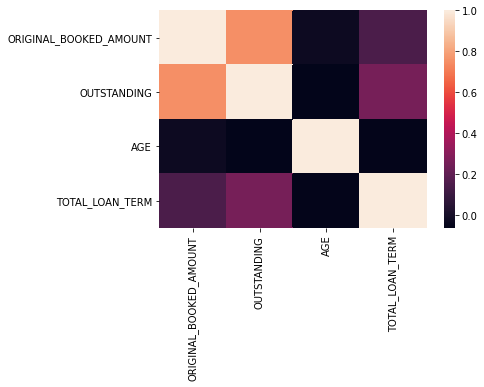

In [9]:
df.find_corr(threshold=0.75)

In [10]:
df.calculation('ORIGINAL_BOOKED_AMOUNT','TOTAL_LOAN_TERM',"INSTALLMENT_SIZE","/")
df.drop_columns(['ORIGINAL_BOOKED_AMOUNT'])
df.find_corr(threshold=0.75)

There is no correlated numeric variables.


#### Categorical

In [11]:
target='BINARIZED_TARGET'
categorical_variables = df.get_columns_bydtype(['object'], target,ignore_target = True)
numeric_variables = df.get_columns_bydtype(["float64", "int64"],target, ignore_target = True)

In [12]:
categorical_variables

['PROGRAM_NAME', 'SEX', 'PROFESSION', 'CAR_TYPE']

# Part II) Risk-based segmentation process:
#### Data cleaning is done prior to this step: 
>datetime types are transformed into numerical variables and there is no correlation between numeric variables at given threshold. 

* All the variables are either **numeric** or **categorical**.
* A **binary target** should be selected and transform it into 0 and 1 class. 
* **Warning**: PLEASE DO NOT modify any missing values as a **Missing Not At Random analysis** is going to be performed. 

#### 1) Missing Not At Random Analysis
To identify different potential segments based on Missing Not At Random method, a report is printed with two lists of variables, **full_file** and **thin_file**.
>Missing Not At Random Research: https://towardsdatascience.com/statistical-test-for-mcar-in-python-9fb617a76eac

In [13]:
df.check_missing()
profile=pd.DataFrame(df.data.copy()) #Make a copy of the df.data prior to perform missing not at random analysis

CAR_TYPE      5.60
PROFESSION    0.12
AGE           0.03
SEX           0.02
dtype: float64


In [14]:
missing_variables=list(df.data.columns[df.data.isna().sum()!=0])
full_file,thin_file=df.missing_not_at_random(missing_variables,target,0.9)

--------------------------------------------------
 Missing Not At Random Report  
--------------------------------------------------
> Missing Not At Random Features are: AGE,SEX at threshold 0.9


>> Target is BINARIZED_TARGET. Therefore we recommend:


>> Thin File Segmentation Variables are:  CAR_TYPE, INSTALLMENT_SIZE, OUTSTANDING, PROFESSION, PROGRAM_NAME, TOTAL_LOAN_TERM


>> Full File Segmentation Variables are:  AGE, CAR_TYPE, INSTALLMENT_SIZE, OUTSTANDING, PROFESSION, PROGRAM_NAME, SEX, TOTAL_LOAN_TERM


In [15]:
df.set_df(profile)

In [16]:
df.drop_row_with_nas('SEX')
df.drop_row_with_nas('AGE')
df.fill_na(categorical_variables,'UNKNOWN')
df.encode_binary([target])
df.check_missing()

Binary encoding is done for: ['BINARIZED_TARGET'].
There is no missing variable.


In [17]:
#Before performing Risk Segmentation Analysis a copy of the df.data should be created to be accessed later for other profile variables.
origindf=pd.DataFrame(df.data.copy())

#### 2) Find the statistically significant segment 
Prior to this step:
> All missing values need to be treated and binary target variable encoded to 1/0 as int, through several methods in CustomDF():

| Purpose   | Method |
|  :----  |    :----         |
|Dropping rows with NaN	|drop_row_with_nas(),|
|Filter columns with NaN by threshold, then drop columns| filter_threshold(threshold, more_or_less),drop_columns()
|Automatic Fill NaN|fill_na_bytype()|
|Manually Fill NaN| fill_na(columns,value)|
|Encoding Binary variables|encode_binary()|

* Passing on df,target,full_file and thin_file into **RiskDataframe()** class

**Before applying find_segment_split() method**, please make sure all categorical variables that are not target remain as object or categorical types

> **ORDERED_NOMINAL**: If a categorical nominal has a meaningful order, store the feature's name into "ordered_nominal"

> **CANDIDATE**: If there is specific feature to be studied, instead of running all features in the full_file list, please specify them in candidate=[]

>**INPUT_VARS**: If there are specific features needed to be used as input variables, instead of full_file, please indicate in input_vars. If thin_file wants to be used, please set input_vars='thin'

**find_segment_split() method:**
* **Non-binary variables** are transformed into numerical by replacing the categories by the Probability of belonging to class 1 (order does not matter); and labelencoding for categorical variables that have meaningful orders.
* Find **statistically significant split** by Chi-Squared Automatic Inference Detection (CHAID) decision tree (https://github.com/Rambatino/CHAID) for both numeric columns and non-binary categorical columns.
* According to the split,transform all variables into binary (1/0), and generate two lists of categorical labels that separated by the splitting point.
* Test GINI performance through **candidate_split_analysis()**, where the parameters for the logisitical regression model is tuned for the X_train/y_train accordingly. 

**The analysis identifies three characteristics**
>**BEST SEGMENTATION** where for BOTH segments, the segment model GINI Coefficients ARE ALL better than that of the FULL POPULATION model

>**GOOD for MODELING** though not the best segmentation but for one segment, the FULL MODEL on BOTH SEGMENTS GINI Coefficients are BETTER than the FULL MODEL on FULL POPULATION 

>**BAD for SEG AND BAD for MODELING**

* NOTE: if there is a CHAID split but the binary variable after transformation has less than 0.1 of variance, the candidate variable does not have a good split.


In [18]:
##Generate REPORT for FULL FILE
dfsg=nm.RiskDataframe()
dfsg.set_df(df,target,full_file,thin_file)
dfsg.find_segment_split()

Segmentation Analysis: Variable by Variable Check for ['PROGRAM_NAME', 'OUTSTANDING', 'SEX', 'PROFESSION', 'CAR_TYPE', 'AGE', 'TOTAL_LOAN_TERM', 'INSTALLMENT_SIZE']
----------------------------------------------------------------------------------------------------
Not good segmentation found for: PROGRAM_NAME,but should be a good feature in modeling.


>>Segment 1: PROGRAM_NAME in (['Auto Loans 50% Down Payment - Employed', 'Auto Loans 50% Down Payment - Self Employed', 'Auto Loans 30% Down Payment - Employed']) [GINI Full Model: 32.6060% / GINI Segmented Model: 32.6244%]
>>Segment 2: PROGRAM_NAME in (['Auto Loans 40% Down Payment - Employed', 'Auto Loans 40% Down Payment - Self Employed', 'Auto Loans 30% Down Payment - Self Employed', 'Pick Up and Small Trucks', 'Auto Loans Special Deals', 'Auto Loans Payroll Clients', 'Auto Loans 20% Down Payment - Employed', 'Auto Loans 20% Down Payment - Self Employed', 'Auto Loans Doctors - Employed', 'Auto Loans 50% Down Payment No Car Prohibiti

In [19]:
##Generate REPORT for THIN FILE
df2=nm.CustomDF()
df2.set_df(origindf)
dfsg2=nm.RiskDataframe()
dfsg2.set_df(df2,target,full_file,thin_file)
dfsg2.find_segment_split(input_vars=dfsg2.thin)

Segmentation Analysis: Variable by Variable Check for ['TOTAL_LOAN_TERM', 'OUTSTANDING', 'CAR_TYPE', 'INSTALLMENT_SIZE', 'PROGRAM_NAME', 'PROFESSION']
----------------------------------------------------------------------------------------------------
There is no statistically significant split found for candidate PROGRAM_NAME, with variance (<0.1).
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
After analysis, OUTSTANDING segmented by [ > 0] / [ < 0] is not good for segmentation nor ideal for modeling.


----------------------------------------------------------------------------------------------------
BEST segmentation found for: SEX


>>Segment 1: SEX in (M) [GINI Full Model: 34.2872% / GINI Segmented Model: 34.3110%]


>>Segment 2: SEX in (F) [GINI Full Model: 37.3911% / GINI Segmented Model: 37.4568%]


------------------------

## CONCLUSION:
### Full File:
> **['PROGRAM_NAME', 'SEX', 'PROFESSION', 'INSTALLMENT_SIZE']** are not good for segmentation but may be good features for modeling purposes.

> **['AGE', 'TOTAL_LOAN_TERM','OUTSTANDING']** are not good for segmentation nor for modeling

> **['CAR_TYPE']** no a statistically significant split is found.

### Thin File:
> **['SEX']** is found to be a BEST segmentation variable.

> **['OUTSTANDING']** are not good for segmentation nor for modeling

> **['CAR_TYPE','PROFESSION','INSTALLMENT_SIZE','AGE','PROFESSION','PROGRAM_NAME']** no a statistically significant split is found.

---